# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# from pyimagesearch import config
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow import keras
import pandas as pd
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow
import os

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten

# Data Gneration and Preprocessing


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def perform_270_clockwise(img):
  t = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  t = cv2.rotate(t, cv2.ROTATE_90_CLOCKWISE)
  t = cv2.rotate(t, cv2.ROTATE_90_CLOCKWISE)
  return t

# Object Detection

In [4]:
class idCardInfoExtraction():
  def __init__(self, model_path):
    self.model_path = model_path
  
  def load_model(self):
    model = tf.keras.models.load_model(self.model_path)
    return model

  def prediction():
    pass

In [6]:
class imageAdjuster():
  def __init__(self, image_path):
    self.image_path = image_path
    self.image = cv2.imread(image_path)
    self.transformed_image = [] # This is to retain the transformation result of perspective_transformation into

  def crop_image(self):
    font = cv2.FONT_HERSHEY_COMPLEX
    borderPoints = []
    gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # Find bounding box and extract ROI
    x,y,w,h = cv2.boundingRect(cnts[0])
    cropped_image = self.image[y:y+h, x:x+w]
    cv2_imshow(cropped_image)
    return cnts[0]
  
  def draw_contours(self, biggest_contour):
    border_points = []
    peri = cv2.arcLength(biggest_contour, True)
    approx = cv2.approxPolyDP(biggest_contour,0.015*peri,True)
    if len(approx) == 4:
        screenCnt = approx
        n = approx.ravel() 
        i = 0
        for j in n : 
          if(i % 2 == 0): 
              x = n[i] 
              y = n[i + 1] 
              border_points.append([x,y])
          i = i + 1

    cv2.drawContours(self.image, [screenCnt], -1, (0, 255, 0), 3) 
    return border_points
  
  def perspectiveTransform(self, border_points):
    a,b,c,d = border_points
    print(border_points)
    pts1 = np.float32([a,d,b,c])
    pts2 = np.float32([[0,0],[0,820],[1280,0],[1280,820]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    transformed = cv2.warpPerspective(self.image,M,(1280,820))
    cv2_imshow(transformed)
    cv2.imwrite('transformed_image.jpg', transformed)
    cv2.waitKey(0)

  def perform_rotation(self, image, num_rotations):
    if num_rotations == 1:
      image_rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif num_rotations == 2:
      image_rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
      image_rotated = cv2.rotate(image_rotated, cv2.ROTATE_90_CLOCKWISE)
    elif num_rotations == 3:
      image_rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
      image_rotated = cv2.rotate(image_rotated, cv2.ROTATE_90_CLOCKWISE)
      image_rotated = cv2.rotate(image_rotated, cv2.ROTATE_90_CLOCKWISE)
    return image_rotated

  def getAveragePixQuarter(self, image):
    # self.transformed_image = cv2.imread(image_path)
    quarter_top_left = image[:len(image)//2,:len(image[0])//2] 
    quarter_bottom_left = image[len(image)//2:,:len(image[0])//2] 
    quarter_top_right = image[:len(image)//2,len(image[0])//2:] 
    quarter_bottom_right = image[len(image)//2:,len(image[0])//2:]
    quarters = {'quarter_top_left': np.average(quarter_top_left), 'quarter_bottom_left': np.average(quarter_bottom_left), 
                         'quarter_top_right': np.average(quarter_top_right), 'quarter_bottom_right': np.average(quarter_bottom_right)}
    sorted_quarters_by_avg = sorted(quarters.items(), key=lambda x:x[1])
    if sorted_quarters_by_avg[-1][0] != "quarter_top_left":
      if sorted_quarters_by_avg[-1][0] == "quarter_bottom_left":
        image = self.perform_rotation(image, 1)
      elif sorted_quarters_by_avg[-1][0] == "quarter_bottom_right":
        image = self.perform_rotation(image, 2)
      elif sorted_quarters_by_avg[-1][0] == "quarter_top_right":
        image = self.perform_rotation(image, 3)
    image_adjusted = cv2.resize(image, (1280, 820))
    print("Final image")
    cv2_imshow(image_adjusted)
    image_adjusted = cv2.rotate(image_adjusted, cv2.ROTATE_90_CLOCKWISE)
    return image_adjusted



In [7]:
class objectDetection(idCardInfoExtraction):
  def __init__(self, model_path, image_path, num_objects):
    super().__init__(model_path)
    self.image_path = image_path
    self.num_objects = num_objects

  def load_image(self):
    # load and resize the image
    image = load_img(self.image_path, target_size=(300, 200))
    # convert it to array
    image = img_to_array(image)
    # take a copy
    image_2 = image
    # normalize them
    image_2 = image_2 / 255
    image = (image-128) / 255.

    # expand dims to be able to go through the model
    image = tf.expand_dims(image, axis=0)
    
    return image, image_2
  
  def prediction(self, model, image):
    pred_y = model.predict(image)
    pred_y = pred_y.reshape(len(pred_y), self.num_objects, -1)
    pred_bboxes = pred_y[..., :4]
    pred_labels = np.argmax(pred_y[..., 4:4+self.num_objects], axis=-1).astype(int)  # take max from probabilities
    return pred_y, pred_bboxes, pred_labels
  
  def visualization(self, image_2, pred_y, pred_bboxes, pred_labels):
    plt.figure(figsize=(5, 12))
    plt.imshow(image_2)
    for bbox, shape in zip(pred_bboxes[0], pred_labels[0]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0]*200, bbox[1]*300), bbox[2]*200, bbox[3]*300, ec='r',lw = 3, fc='none'))
        plt.annotate(shape, (bbox[0]*200, bbox[1]*300 + bbox[3]*300 + 0.7),clip_on=False, bbox={'fc': 'w', 'ec': 'none', 'pad': 1, 'alpha': 0.2})


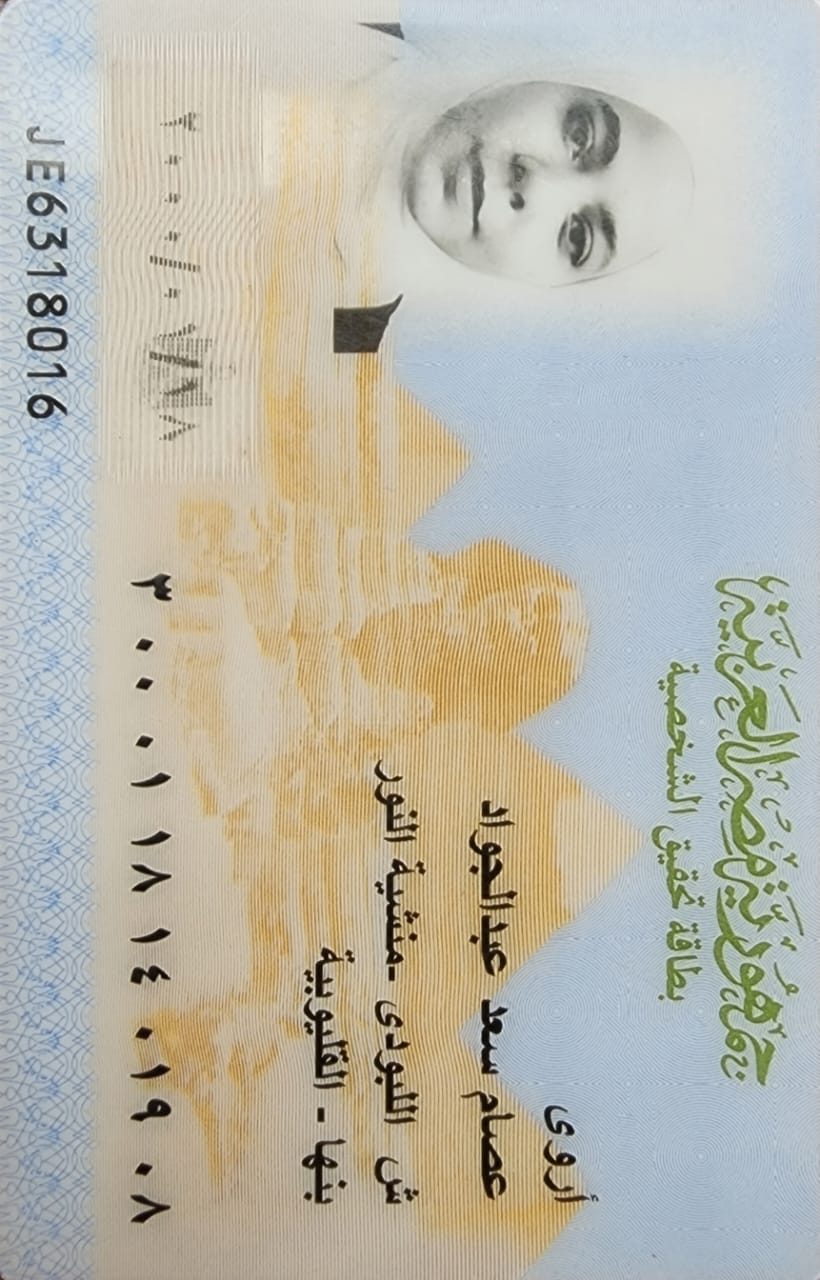

[[819, 0], [819, 1279], [6, 1279], [0, 2]]


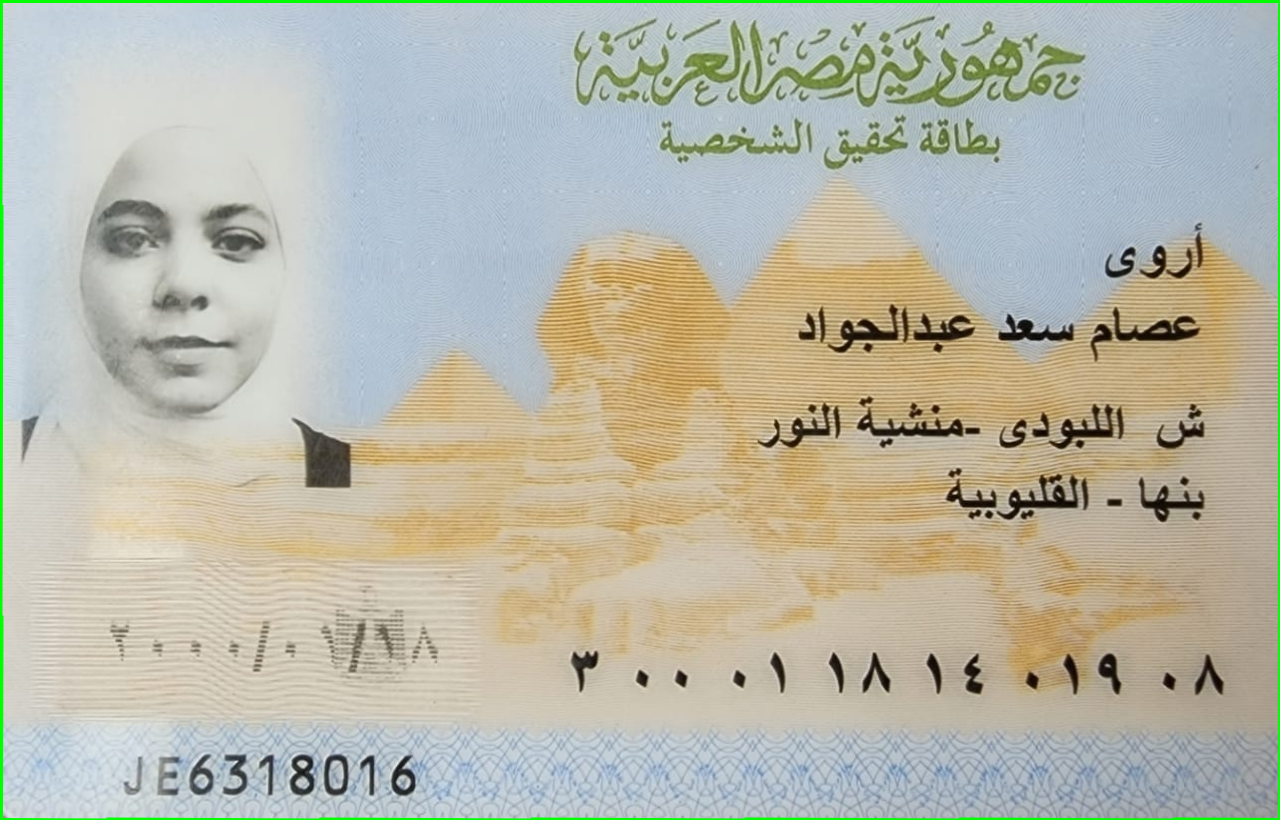

Final image


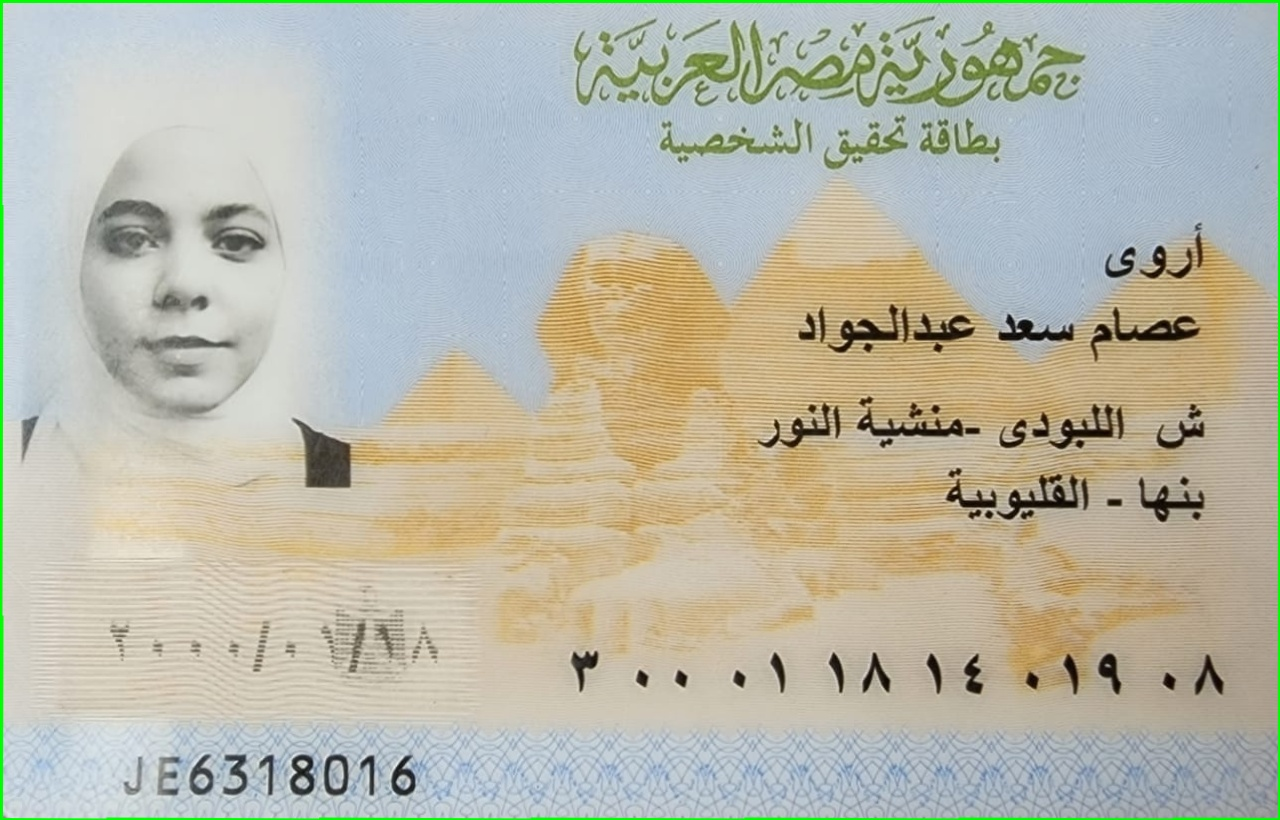

True

In [8]:
# test
model_path = '/content/drive/MyDrive/Copy of id_detection.h5'
image_path = '/content/Arwa.jpeg'

adj = imageAdjuster(image_path)

############################
biggest_contour = adj.crop_image()
biggest_contour = biggest_contour[::-1]
borders = adj.draw_contours(biggest_contour)
adj.perspectiveTransform(borders)
transformed = cv2.imread('transformed_image.jpg')
adjusted_image = adj.getAveragePixQuarter(transformed)
############################
adjusted_image = cv2.resize(adjusted_image, (200, 300))
cv2.imwrite('adjusted_image.jpg', adjusted_image)
# adjusted_image = cv2.rotate(adjusted_image, cv2.ROTATE_90_CLOCKWISE)




1/1 [==============================] - 7s 7s/step


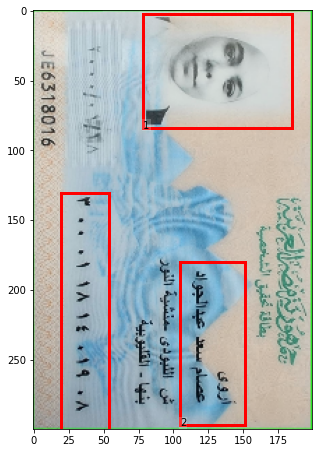

In [9]:
num_objects = 3
od = objectDetection(model_path, '/content/adjusted_image.jpg', num_objects)

model = od.load_model()

img, img_2 = od.load_image()

pred_y, pred_bboxes, pred_labels = od.prediction(model, img)
od.visualization(adjusted_image, pred_y, pred_bboxes, pred_labels)

<ipython-input-10-53067b0d4682>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  frame_normed = np.array(frame_normed, np.int)


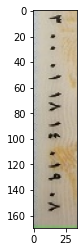

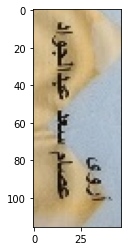

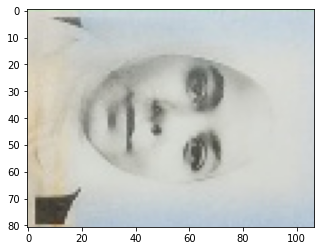

In [10]:
cropped_images = ['id.png', 'Names.png', 'Photo.png']
i = 0
for bbox, shape in zip(pred_bboxes[0], pred_labels[0]):
  cropped_image = img_2[int(bbox[1]*300):int(bbox[1]*300+bbox[3]*300), int(bbox[0]*200):int(bbox[0]*200+bbox[2]*200)]
  plt.figure()
  plt.imshow(cropped_image)

  frame_normed = 255 * (cropped_image - cropped_image.min()) / (cropped_image.max() - cropped_image.min())
  frame_normed = np.array(frame_normed, np.int)

  cv2.imwrite(cropped_images[i], frame_normed)
  plt.savefig('spec',bbox_inches='tight',transparent=True, pad_inches=0)
  # plt.imwrite(cropped_images[i], cropped_image)
  i +=1

(116, 47, 3)
(250, 148, 3)


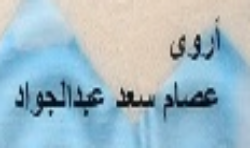

In [11]:
t = cv2.imread('/content/Names.png')
print(t.shape)
t = cv2.resize(t, (148,250))
print(t.shape)
t = perform_270_clockwise(t)
cv2_imshow(t)


# Arabic OCR

In [12]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!sudo apt-get install tesseract-ocr-ara

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-ara tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 21 not upgraded.
Need to get 5,439 kB of archives.
After this operation, 17.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Get:4 http://archive.ubuntu.

In [14]:
import numpy as np
import os  

def remove_noise(image,median):
    return cv2.medianBlur(image,median)
def dilate(image, dialation):
    kernel = np.ones((dialation,dialation),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

In [15]:
import pytesseract

def preprocess(image, median, dialation):
  grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  img_2 = remove_noise(grayImage, median)
  # img_2 = increase_contrast(img_2)
  img_2 = dilate(img_2, dialation)
  (thresh, blackAndWhiteImage) = cv2.threshold(img_2, 100, 255, cv2.THRESH_BINARY)
  cv2_imshow(blackAndWhiteImage)
  return blackAndWhiteImage

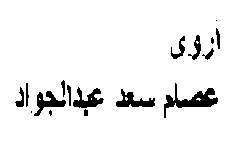

['اروى', 'عصام', 'سعد', 'عبدالجواد']


In [16]:
# img = cv2.imread()

firstName = preprocess(t, 1, 1)

arabic_text=pytesseract.image_to_string(firstName, lang='ara',config= ".")

print(arabic_text.split())

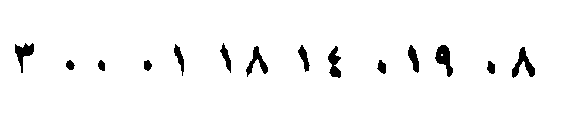

٨ ٠ ٩ ١ ٠ ٤ ١ ٨ ١ ١ ٠ ٠ ٠ ٣ 
  

In [17]:
import shutil

shutil.copyfile("/content/drive/MyDrive/Asses/arabic_numbers.traineddata", "/usr/share/tesseract-ocr/4.00/tessdata/arabic_numbers.traineddata")
idd = cv2.imread('id.png')
idd = perform_270_clockwise(idd)
idd = cv2.resize(idd, (580, 120))

id = preprocess(idd, 1, 1)

id=pytesseract.image_to_string(id , lang='arabic_numbers',config= ".")
for i in id:
  if i != ' ':
    print(i, end=" ")

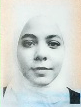

In [28]:
personal_photo = cv2.imread('/content/Photo.png')
personal_photo = perform_270_clockwise(personal_photo)
cv2.imwrite(f"/content/Face_train/{arabic_text}.jpg", personal_photo)
cv2.imwrite(f"/content/Face_test/{arabic_text}.jpg", personal_photo)
cv2_imshow(personal_photo)

In [ ]:
# import os
# import shutil

# os.rename("/content/arabic_numbers.traineddata", "/usr/share/tesseract-ocr/4.00/tessdata/arabic_numbers.traineddata")
# os.replace("/content/arabic_numbers.traineddata", "/usr/share/tesseract-ocr/4.00/tessdata/arabic_numbers.traineddata")
# shutil.move("/content/arabic_numbers.traineddata", "/usr/share/tesseract-ocr/4.00/tessdata/arabic_numbers.traineddata")

# Spell Correction

In [19]:
class spellCorrection(idCardInfoExtraction):
  def __init__(self, model_path):
    super().__init__(model_path)
    self.target_token_index = None 
    self.input_token_index = None
    self.reverse_input_char_index = None
    self.reverse_target_char_index = None
    self.num_decoder_tokens = 39
    self.num_encoder_tokens = 32
    self.max_decoder_seq_length = 11
    self.max_encoder_seq_length = 9
    # self.encoder_model = None 
    # self.decoder_model = None

  def reconstruct_model(self, model, latent_dim = 128):
    encoder_inputs = model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    decoder_inputs = model.input[1]  # input_2
    decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
    decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.layers[3]
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h_dec, state_c_dec]
    decoder_dense = model.layers[4]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = keras.Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )
    return encoder_model, decoder_model

  def victorize_data(self, input_characters, target_characters):
    self.input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
    self.target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
    self.reverse_input_char_index = dict((i, char) for char, i in self.input_token_index.items())
    self.reverse_target_char_index = dict((i, char) for char, i in self.target_token_index.items())

  def decode_sequence(self, input_seq, encoder_model, decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, self.num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, self.target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = self.reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > self.max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, self.num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        # Update states
        states_value = [h, c]
    return decoded_sentence

  def prediction(self, test_text, enc_model, dec_model):
    encoder_test_data = np.zeros(
        (1, self.max_encoder_seq_length, self.num_encoder_tokens), dtype="float32")

    for t, char in enumerate(test_text):
        encoder_test_data[0, t, self.input_token_index[char]] = 1.0

    decoded_sentence = self.decode_sequence(encoder_test_data, enc_model, dec_model)
    print(len(decoded_sentence), decoded_sentence)

In [ ]:
input_chars = [' ','ء','ئ','ا','ب','ة','ت','ث','ج','ح','خ','د','ذ','ر','ز','س','ش','ص','ض','ط','ظ','ع','غ','ف','ق','ك','ل','م','ن','ه','و','ي']
target_chars = [' ','\t','\n','ء','آ','أ','ؤ','إ','ئ','ا','ب','ة','ت','ث','ج','ح','خ','د','ذ','ر','ز','س','ش','ص','ض','ط','ظ','ع','غ','ف','ق','ك','ل','م','ن','ه','و','ى','ي']

In [ ]:
# test

model_path = '/content/drive/MyDrive/Copy of Id_card_spell_correction/id_names_spell_correction_97.h5'
spell_correction = spellCorrection(model_path)

spell_model = spell_correction.load_model()
spell_correction.victorize_data(input_chars, target_chars)
enc_model, dec_model = spell_correction.reconstruct_model(spell_model)
test_text = arabic_text.split()[0]
spell_correction.prediction(test_text, enc_model, dec_model)


# Face Verification

In [22]:
import os
parent_dir = os.getcwd()
path_train = os.path.join(parent_dir, 'Face_train')
path_test = os.path.join(parent_dir, 'Face_test')
# os.mkdir(path_train)
# os.mkdir(path_test)
train_imgs_path = '/content/Face_train'
test_imgs_path = '/content/Face_test'

In [21]:
print(train_imgs_path)

/content/Face_train


In [23]:
! pip3 install face_recognition
!apt update
!apt install -y cmake
!pip install dlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=0c9f6421b706010f56e4d720601f75e7dca059828c6a190222cc727a1101501a
  Stored in directory: /root/.cache/pip/wheels/b4/4b/8f/751e99d45f089bdf366a7d3e5066db3c2b84a62e4377f534d7
Successfully built face-recognition-models
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer

In [24]:
import os
import face_recognition as frec
import cv2 
import imutils
import numpy as np
import matplotlib.pyplot as plt

In [29]:
## read some  images to train and know their labels
# path => of the folder that contain the images

imgs_list = []
names_list = []
imgs_name = os.listdir(train_imgs_path)

for img_name in imgs_name:
  img = cv2.imread(f'{train_imgs_path}/{img_name}')
  imgs_list.append(img)
  names_list.append(img_name.split('.')[0])

In [30]:
## Encoding train imgs

def Encoding(imges):
  encod_list =[]
  for img in imgs_list:
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    encod = frec.face_encodings(img)[0]
    encod_list.append(encod)
  return encod_list

encoded_list = Encoding(imgs_list)

0.0 اروى
عصام سعد عبدالجواد



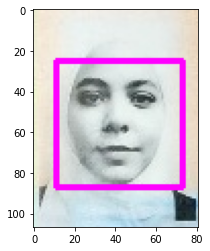

In [31]:
## face recognition
# picture from object detection model



test_imgs_name = os.listdir(test_imgs_path)
for test_img in test_imgs_name:

  img = frec.load_image_file(test_imgs_path + '/'+test_img)
  face_loc = frec.face_locations(img)
  newimg_encod = frec.face_encodings(img,face_loc)

  
  for i,encoded_img in enumerate(encoded_list):
    matches = frec.compare_faces(encoded_img,newimg_encod)
    distance = frec.face_distance(encoded_img,newimg_encod)

    if matches[0]:
      print(distance[0],names_list[i])
      loc=[]
      loc = frec.face_locations(img)[0]
      cv2.rectangle(img,(loc[3],loc[0]),(loc[1],loc[2]),(255,0,255),2)
      plt.imshow(img)
      plt.show()
      break
      
  else:
    print('UNKNOWN')
    plt.imshow(img)
    plt.show()
